# Excited States via EOM-VQE (Tangent-Space Full Response)

This notebook validates that:
- A reference ground-state VQE run produces converged parameters θ*
- EOM-VQE builds the **full-response** tangent-space generalized eigenproblem (A/B blocks + indefinite metric)
- It returns physical excitation energies ω (positive roots) and excited energies E0 + ω

It prints:
- Lowest exact eigenvalues of a reference Hamiltonian
- Reference VQE energy E0
- EOM excitation energies ω_i and excited energies E0 + ω_i
- |ΔE| vs nearest exact eigenvalue (sanity)
- Diagnostics: overlap spectrum, kept rank, conditioning, symmetry metrics

In [1]:
import numpy as np
import pennylane as qml
from pennylane import qchem

from vqe.eom_vqe import run_eom_vqe

## Configuration

In [2]:
molecule = "H2"
k = 4

ansatz_name = "UCCSD"
optimizer_name = "Adam"
steps = 80
stepsize = 0.2
seed = 0
mapping = "jordan_wigner"

fd_eps = 1e-3
eps = 1e-10
omega_eps = 1e-12

force = False

## Exact spectrum benchmark (reference Hamiltonian)

In [3]:
sym = ["H", "H"]
coords = np.array(
    [
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.7414],
    ],
    dtype=float,
)
basis = "sto-3g"

H_ref, n_wires = qchem.molecular_hamiltonian(sym, coords, basis=basis, unit="Angstrom")

Hmat = np.array(qml.matrix(H_ref), dtype=complex)
exact_evals = np.sort(np.linalg.eigvalsh(Hmat).real)

print(f"Molecule: {molecule}")
print(f"Qubits:   {n_wires}")
print(f"Basis:    {basis}")
print(f"Lowest {max(10, k)} exact eigenvalues (Ha):")
for i, e in enumerate(exact_evals[: max(10, k)]):
    print(f"#{i:>2}: {float(e): .10f}")

Molecule: H2
Qubits:   4
Basis:    sto-3g
Lowest 10 exact eigenvalues (Ha):
# 0: -1.1372701749
# 1: -0.5387095807
# 2: -0.5387095807
# 3: -0.5324790143
# 4: -0.5324790143
# 5: -0.5324790143
# 6: -0.4469857253
# 7: -0.4469857253
# 8: -0.1699013991
# 9:  0.2378052722


## Helpers

In [4]:
def _nearest_exact_energy(E: float, exact: np.ndarray) -> tuple[float, float, int]:
    diffs = np.abs(exact - float(E))
    j = int(np.argmin(diffs))
    return float(exact[j]), float(diffs[j]), j


def summarize_eom(result: dict, exact: np.ndarray, *, label: str) -> None:
    E0 = float(result["reference_energy"])
    omegas = np.array(result["excitations"], dtype=float)
    energies = np.array(result["eigenvalues"], dtype=float)

    print("\n" + "=" * 80)
    print(label)
    print("=" * 80)
    print(f"E0 (reference): {E0:+.10f} Ha")
    print(f"num_qubits:     {int(result['num_qubits'])}")
    print()

    for i, (w, E) in enumerate(zip(omegas, energies)):
        target, err, j = _nearest_exact_energy(float(E), exact)
        print(
            f"root {i:>2}:  ω = {float(w):+.10f} Ha   "
            f"E = E0+ω = {float(E):+.10f} Ha   "
            f"nearest exact[{j}] = {target:+.10f} Ha   |ΔE| = {err:.3e} Ha"
        )

## EOM-VQE (tangent-space full response)

Step 01/80: E = -1.116684 Ha
Step 02/80: E = -1.136994 Ha
Step 03/80: E = -1.131007 Ha
Step 04/80: E = -1.122700 Ha
Step 05/80: E = -1.130115 Ha
Step 06/80: E = -1.133031 Ha
Step 07/80: E = -1.134496 Ha
Step 08/80: E = -1.134652 Ha
Step 09/80: E = -1.132102 Ha
Step 10/80: E = -1.130839 Ha
Step 11/80: E = -1.133769 Ha
Step 12/80: E = -1.136856 Ha
Step 13/80: E = -1.136817 Ha
Step 14/80: E = -1.134837 Ha
Step 15/80: E = -1.133732 Ha
Step 16/80: E = -1.134458 Ha
Step 17/80: E = -1.135957 Ha
Step 18/80: E = -1.136742 Ha
Step 19/80: E = -1.136508 Ha
Step 20/80: E = -1.136055 Ha
Step 21/80: E = -1.135899 Ha
Step 22/80: E = -1.135938 Ha
Step 23/80: E = -1.136174 Ha
Step 24/80: E = -1.136688 Ha
Step 25/80: E = -1.137068 Ha
Step 26/80: E = -1.136886 Ha
Step 27/80: E = -1.136406 Ha
Step 28/80: E = -1.136270 Ha
Step 29/80: E = -1.136684 Ha
Step 30/80: E = -1.137181 Ha
Step 31/80: E = -1.137213 Ha
Step 32/80: E = -1.136850 Ha
Step 33/80: E = -1.136654 Ha
Step 34/80: E = -1.136858 Ha
Step 35/80: E 

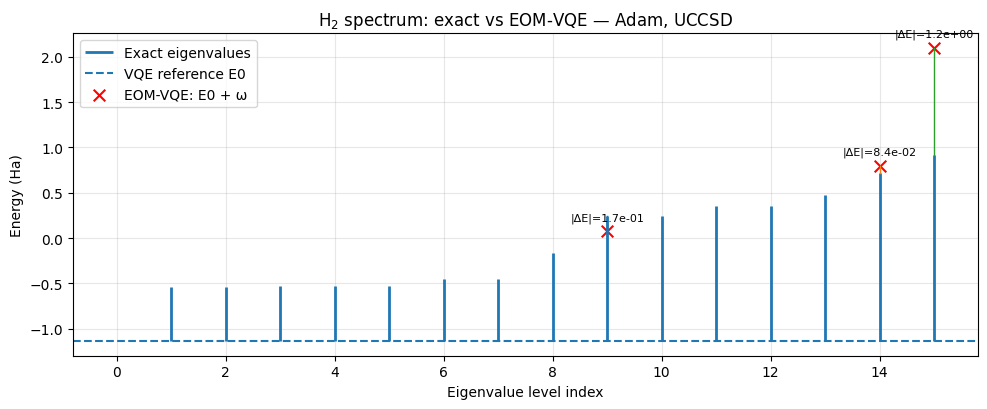

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/eom_vqe_spectrum_UCCSD_Adam_s0.png


In [5]:
eom_res = run_eom_vqe(
    molecule=molecule,
    k=k,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    mapping=mapping,
    fd_eps=fd_eps,
    eps=eps,
    omega_eps=omega_eps,
    force=force,
    plot=True,
    save=True,
)

## Summary table

In [6]:
summarize_eom(eom_res, exact_evals, label="Noiseless EOM-VQE (tangent-space full response)")


Noiseless EOM-VQE (tangent-space full response)
E0 (reference): -1.1372694521 Ha
num_qubits:     4

root  0:  ω = +1.2095776159 Ha   E = E0+ω = +0.0723081638 Ha   nearest exact[9] = +0.2378052722 Ha   |ΔE| = 1.655e-01 Ha
root  1:  ω = +1.9347361061 Ha   E = E0+ω = +0.7974666540 Ha   nearest exact[14] = +0.7137539937 Ha   |ΔE| = 8.371e-02 Ha
root  2:  ω = +3.2342055068 Ha   E = E0+ω = +2.0969360547 Ha   nearest exact[15] = +0.9201067009 Ha   |ΔE| = 1.177e+00 Ha


## Diagnostics: overlap spectrum and solver metrics

In [7]:
diag = eom_res.get("diagnostics", {})

S_eigs = diag.get("S_eigs", [])
print("Overlap eigenvalues (S):")
for i, x in enumerate(S_eigs):
    print(f"  s[{i:>2}] = {float(x): .6e}")

print()
print(f"kept_rank:         {diag.get('kept_rank', None)}")
print(f"subspace_dim:      {diag.get('subspace_dim', None)}")
print(f"eps:              {diag.get('eps', None)}")
print(f"fd_eps:           {diag.get('fd_eps', None)}")
print(f"omega_eps:        {diag.get('omega_eps', None)}")
print(f"S_condition_kept: {diag.get('S_condition_kept', None)}")

print()
print("Symmetry diagnostics (dimensionless deviations):")
print(f"  A_hermitian_deviation:            {diag.get('A_hermitian_deviation', None)}")
print(f"  S_hermitian_deviation:            {diag.get('S_hermitian_deviation', None)}")
print(f"  B_symmetric_deviation:            {diag.get('B_symmetric_deviation', None)}")
print(f"  B_hermitian_deviation:            {diag.get('B_hermitian_deviation', None)}")
print(f"  Bt_symmetric_deviation_projected: {diag.get('Bt_symmetric_deviation_projected', None)}")
print(f"  K_hermitian_deviation_projected:  {diag.get('K_hermitian_deviation_projected', None)}")

print()
print("Raw eigenvalue range (projected K):")
print(f"  raw_eigs_min: {diag.get('raw_eigs_min', None)}")
print(f"  raw_eigs_max: {diag.get('raw_eigs_max', None)}")
print(f"  num_pos_roots: {diag.get('num_pos_roots', None)}")

Overlap eigenvalues (S):
  s[ 0] =  2.495892e-01
  s[ 1] =  2.500000e-01
  s[ 2] =  2.504100e-01

kept_rank:         3
subspace_dim:      3
eps:              1e-10
fd_eps:           0.001
omega_eps:        1e-12
S_condition_kept: 1.0032886572390758

Symmetry diagnostics (dimensionless deviations):
  A_hermitian_deviation:            0.0
  S_hermitian_deviation:            0.0
  B_symmetric_deviation:            1.9834028777494633e-17
  B_hermitian_deviation:            1.9834028777494633e-17
  Bt_symmetric_deviation_projected: 8.230965489186306e-17
  K_hermitian_deviation_projected:  0.0

Raw eigenvalue range (projected K):
  raw_eigs_min: -4.839134580312411e-16
  raw_eigs_max: 3.234205506828144
  num_pos_roots: 3
